In [1]:
import os
import pickle
import shutil 
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math
from IPython import embed

Using MPI version 4.0, 1 processes


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# set up simulation constants

resolution =30

n_air = 1.0000003
n_Si = 1.45
n_SiO2 = 3.48

a = 0.5   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_hole = 5
height_SiO2 = height_hole
height_air = 7+2*pml_thickness
height_Si_initial= 0.5*(height_air-height_hole)
height_Si_add = 0.75*0.5*height_SiO2


cell_x = a
cell_y = a
cell_z = height_air

z_air = height_air

center_air = 0 
center_SiO2 = 0 
center_hole = 0
center_Si_initial = -0.5*height_hole -0.25*(height_air-height_hole)+0.005
center_Si_add = 0.5*height_Si_add

In [3]:

#initial_geometry setup

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_air), 
                    center=mp.Vector3(0,0,center_air),
                    material=mp.Medium(index=n_air)),
           mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_Si_initial),
                   center=mp.Vector3(0,0,center_Si_initial),
                   material=mp.Medium(index=n_Si))]


k_point = mp.Vector3(0,0,0)

## source ##
center_source = -0.5*height_hole-0.125*(height_air-height_hole) 
source_cmpt = mp.Ey

wavelength = 1.55
freq = 1 / wavelength


sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]


## flux monitor ##
nfreq = 1
df = 0
fr_center = 0.5*height_hole+0.125*(height_air-height_hole)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))



if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]




In [4]:
sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)
flux_object = sim.add_flux(freq, df, nfreq, fr)


sim.run(until=200)


combined_initial_flux = mp.get_fluxes(flux_object)[0]



# In[4]:


geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_SiO2), 
                    center=mp.Vector3(0,0,center_SiO2),
                    material=mp.Medium(index=n_SiO2)))

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_Si_add), 
                    center=mp.Vector3(0,0,center_Si_add),
                    material=mp.Medium(index=n_Si)))


## initialize matrix for data collection ##
##########################################

num_holes = 15  # this is the number of pillars we will build
num_height = 15
min_r = 0.1
max_r = 0.245
min_h = 1.02
max_h = 5
data = np.zeros((4,num_holes))






-----------
Initializing structure...
Padding x to even number of grid points.
Padding y to even number of grid points.
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00439405 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.56667 with resolution 30
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
time for set_epsilon = 0.125848 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 172.85/200.0 = 86.4% done in 4.0s, 0.6s to go
on time step 10385 (time=173.083), 0.000385278 s/step
run 0 finished at t = 200.0 (12000 timesteps)


In [ ]:
sim.reset_meep()

combined_data = {}
depth_list = []

def run_sim(radius,height,sim) :
    print(radius)
    
    geometry.append(mp.Cylinder(radius=radius,
                        height=height,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_hole),
                        material=mp.Medium(index=n_air)))
                
                
    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)
                    #save_geometry(sim, radius, height)
                        
    flux_object = sim.add_flux(freq, df, nfreq, fr)  
    sim.run(until=200)
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 

    if phase<-np.pi:
        phase = phase +2*np.pi
    elif phase>-np.pi and phase<np.pi:
        phase = phase
    else:
        phase = phase - 2*np.pi
                                                    
   #radii_list.append(radius)
   # flux_list.append(flux)
   # phase_list.append(phase)
   # new_heightlist.append(height)
                                                                        
    
    sim.reset_meep()
    geometry.pop(-1)

    return phase, flux

def save_geometry(sim, radius, height):
    fig = plt.figure(figsize=(10,10))
    sim.plot2D(output_plane=plot_plane)

pbar = tqdm(total=num_height*num_holes,leave=False)
new_heightlist =[]
for h, height in enumerate(np.linspace(min_h,max_h,num_height)):
    radii_list=[] 
    flux_list, phase_list=[],[]
    new_heightlist.append(height)
    for r, radius in enumerate(np.linspace(min_r,max_r,num_holes)):
        radii_list.append(radius)
        phase, flux=run_sim(radius,height,sim)
        phase_list.append(phase)
        flux_list.append(flux)
        
        print(h,r)
        print("#########################################")
        print(f"phase: {phase} flux: {flux} radis:{radius} depth:{height}")
        pbar.update(1)
    combined_data[h] = {
            'height' : height,
            'flux' : flux_list,
            'phase' : phase_list,
            'radii' : radii_list,
            'new_height' : new_heightlist 
             }
       
pbar.close()

In [5]:
import pickle
radius_data = pickle.load(open("/develop/results/radius_data.pkl", "rb"))

In [8]:
print(radius_data)
# print(combined_initial_flux)

{0: {'radius': 0.1, 'flux': 24.867074397621547, 'phase': [2.749705709742415, 2.649104158970481, 2.3353606306114933, 2.34017310852659, 2.1578864041516734, 1.8668670883800764, 1.6805833873025018, 1.606337849206252, 1.2703688138180924, 1.0952258168071012, 0.9766955316590965, 0.6462327121057923, 0.3366534440016339, 0.41059713331536907, 0.17957786883601548], 'depth': [1.02, 1.3042857142857143, 1.5885714285714285, 1.872857142857143, 2.1571428571428575, 2.4414285714285713, 2.725714285714286, 3.0100000000000002, 3.2942857142857145, 3.5785714285714287, 3.862857142857143, 4.147142857142857, 4.431428571428572, 4.715714285714286, 5.0], 'new_radius': [0.1, 0.11035714285714286, 0.12071428571428572, 0.13107142857142856, 0.14142857142857143, 0.1517857142857143, 0.16214285714285714, 0.1725, 0.18285714285714286, 0.19321428571428573, 0.20357142857142857, 0.2139285714285714, 0.22428571428571428, 0.23464285714285713, 0.245]}, 1: {'radius': 0.11035714285714286, 'flux': 22.044237998119467, 'phase': [2.672218

In [6]:
## pickle operations

def calculate_average(numbers):
    total = sum(numbers)
    count = len(numbers)
    average = total / count
    return average

for key in radius_data:
    data = radius_data[key]['flux']
    radius_data[key]['flux'] = calculate_average(data)

In [20]:
c

24.867074397621547
22.044237998119467
20.078808844641234
19.428599268106506
19.638044595077538
21.226976594258645
21.68223068917372
23.41832080942066
26.015788458197253
24.80533289166734
26.802701623520615
27.734804597954238
28.887672320857497
31.272208027246347
32.736661455394135


In [11]:
import seaborn as sns
import csv
import pandas as pd

In [28]:
file_name = 'radius_data.csv'
field_names = list(radius_data.keys())
print(field_names)

with open(file_name, 'w', newline = '') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()

    for i in range(len(radius_data[field_names[0]])):
        row = {key:radius_data[key][i] for key in field_names}
        writer.writerow(row)
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


KeyError: 0

In [39]:
df = pd.read_csv('radius_data.csv')
print(radius_data)

{0: {'radius': 0.1, 'flux': 24.867074397621547, 'phase': [2.749705709742415, 2.649104158970481, 2.3353606306114933, 2.34017310852659, 2.1578864041516734, 1.8668670883800764, 1.6805833873025018, 1.606337849206252, 1.2703688138180924, 1.0952258168071012, 0.9766955316590965, 0.6462327121057923, 0.3366534440016339, 0.41059713331536907, 0.17957786883601548], 'depth': [1.02, 1.3042857142857143, 1.5885714285714285, 1.872857142857143, 2.1571428571428575, 2.4414285714285713, 2.725714285714286, 3.0100000000000002, 3.2942857142857145, 3.5785714285714287, 3.862857142857143, 4.147142857142857, 4.431428571428572, 4.715714285714286, 5.0], 'new_radius': [0.1, 0.11035714285714286, 0.12071428571428572, 0.13107142857142856, 0.14142857142857143, 0.1517857142857143, 0.16214285714285714, 0.1725, 0.18285714285714286, 0.19321428571428573, 0.20357142857142857, 0.2139285714285714, 0.22428571428571428, 0.23464285714285713, 0.245]}, 1: {'radius': 0.11035714285714286, 'flux': 22.044237998119467, 'phase': [2.672218

In [ ]:
sns.set_theme(style="ticks")

# Load the dataset and initialize the figure
g = sns.JointGrid(data=df, x="radius", y="flux", marginal_ticks=True)

# y axis
g.ax_joint.set(yscale="linear")

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

In [ ]:
sns.set_theme(style="ticks")

# Load the dataset and initialize the figure
g = sns.JointGrid(data=df, x="radius", y="phase", marginal_ticks=True)

# y axis
g.ax_joint.set(yscale="linear")

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

[0.1, 0.11035714285714286, 0.12071428571428572, 0.13107142857142856, 0.14142857142857143, 0.1517857142857143, 0.16214285714285714, 0.1725, 0.18285714285714286, 0.19321428571428573, 0.20357142857142857, 0.2139285714285714, 0.22428571428571428, 0.23464285714285713, 0.245]
[24.867074397621547, 22.044237998119467, 20.078808844641234, 19.428599268106506, 19.638044595077538, 21.226976594258645, 21.68223068917372, 23.41832080942066, 26.015788458197253, 24.80533289166734, 26.802701623520615, 27.734804597954238, 28.887672320857497, 31.272208027246347, 32.736661455394135]


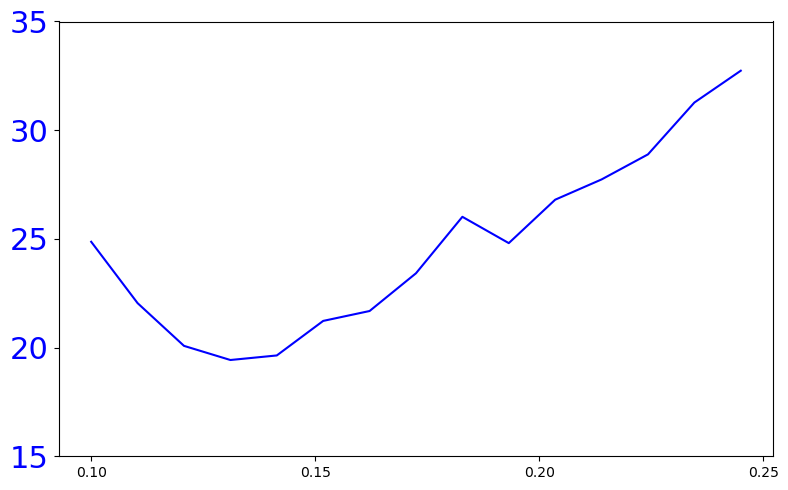

In [57]:

#plt.style.use('seaborn')

#results = {"radii": radii, "flux": flux_list, "phase": phase_list}
# this section plots radius vs. phas and transmission
radius = []
flux = []
tickfontsize=22
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

#fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

#ax.set_title("Transmission Magnitude",fontsize=titlefontsize)

#ax.set_xlabel("Radius",fontsize=labelfontsize)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.250])
#ax.set_xticklabels([0,50,100,150,200,250],fontsize=tickfontsize)
#ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
for key in radius_data:
    radius.append(radius_data[key]['radius'])
    flux.append(radius_data[key]['flux'])
print(radius)
print(flux)
ax.plot(radius, flux, 'b', label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')
ax.set_yticks([15,20,25,30,35])
ax.set_yticklabels([15,20,25,30,35],fontsize=tickfontsize)
#ax.set_yticks([0.6,0.7,0.8,0.9,1])
#ax.set_yticklabels([60,70,80,90,100],fontsize=ticgit config --gzlobal user.email "you@example.com"kfontsize)

# twin1 = ax.twinx()
# #ax[1].set_title("Transmission Phase",fontsize=titlefontsize)S
# #ax[1].set_xlabel("Radius (nm)",fontsize=labelfontsize)
# #ax[1].set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])cd meep

# #ax[1].set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
# twin1.set_ylim([-np.pi,np.pi])
# twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
# twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
# twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
# twin1.plot(radii,phase_list,'r',label='Phase')
# twin1.tick_params(axis='y', labelcolor = 'red')
#ax[1].legend(loc="upper right")
#plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()